# Predicting horror authors - the data

First off, we will import the libraries we need. This is mostly Keras stuff, but also sklearn for train_test split and label encoding.

I also define a numPy random seed. I chose this before doing any work on the notebook, and the reason for doing it, is that it enables consistent results. If I did not set it, the model predictions would be different every time.

In [0]:
import pandas as pd
import numpy as np

from collections import defaultdict

import keras
import keras.backend as K
from keras.layers import Dense, GlobalAveragePooling1D, Embedding, LSTM, Input, Bidirectional, Dropout, Flatten
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

np.random.seed(7)

I will then download the train and test data from Github.

In [66]:
!wget https://raw.githubusercontent.com/SDS-AAU/M3-2018/master/assignments/individual/data/train.csv
!wget https://raw.githubusercontent.com/SDS-AAU/M3-2018/master/assignments/individual/data/test.csv

--2018-11-12 16:41:03--  https://raw.githubusercontent.com/SDS-AAU/M3-2018/master/assignments/individual/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3295644 (3.1M) [text/plain]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>]   3.14M  --.-KB/s    in 0.04s   

2018-11-12 16:41:04 (71.1 MB/s) - ‘train.csv.1’ saved [3295644/3295644]

--2018-11-12 16:41:06--  https://raw.githubusercontent.com/SDS-AAU/M3-2018/master/assignments/individual/data/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135

Let's import the data we just downloaded into a couple of DataFrames.

In [0]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [68]:
train_data.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [69]:
test_data.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


As we can see, the training data consists of an id, the text and author, while the test data has no information about author.

# Keras tokenizer, MLP, FastText and LSTM

The first approach I will use is the built in Tokenizer in Keras. This is a fast, but relatively dumb technique for vectorizing the sentences. It basically creates a unique integer for each word, leaving out commas, punctuation and special characters by default.

First off, let's convert our authors to something our ML models can use with labelencoder. I then convert them to a binary representation using the `to_categorical` function from Keras.

In [0]:
y = labelencoder.fit_transform(train_data.author)
y = to_categorical(y)

Below, I define a preprocessing function. This uses Tokenizer to convert our text. Please note the `filters`, where the excluded characters are defined. Also note that I pad the sequences to the same length, with a maximum length of 256. This can be experimented with as one pleases.

One thing that changes the result a surprising amount is setting lowercase to True and including punctuation. This is probably because the different authors have different punctuation and capitalization styles.

In [0]:
def preprocess(df, lowercase=False):
  tokenizer = Tokenizer(lower=lowercase, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
  tokenizer.fit_on_texts(df.text)
  docs = tokenizer.texts_to_sequences(df.text)
  docs = pad_sequences(sequences=docs, maxlen=256)
  
  return docs

Let's use the preprocess function on our actual training data.

In [0]:
train_text = preprocess(train_data)

In [73]:
train_text

array([[    0,     0,     0, ...,    97,     1,   448],
       [    0,     0,     0, ...,     6,   438,  2393],
       [    0,     0,     0, ...,   359,   497,  2732],
       ...,
       [    0,     0,     0, ...,    98, 16754, 16332],
       [    0,     0,     0, ...,    60,  9670,   550],
       [    0,     0,     0, ...,     9,     2,  6145]], dtype=int32)

As you can see, the words in the sentences are now represented with an integer. This is fine for now. Let's split it up into our training and testing data using the usual train_test_split with a 20% split.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(train_text, y, test_size=0.2)

## MLP

The first Neural Network I will use is a Densely Connected Neural Network, much like the ones from the Datacamp course on Deep Learning. In this case, I use the `adam` optimizer and a `relu` activation function for each layer until the output, where I use `softmax` to better represent the outliers. Since we are categorizing, I use `categorical_crossentropy` for my loss function. All of these can be experimented with of cause.
I also set the `kernel_initializer` to `he_normal`. The default in Keras, `glorot_uniform`, did not perform as well, so I just left it at the best performning one. `kernel_initializer` sets the initial random weights for the network layers.

I also add a Dropout layer for each Dense layer. In my case, I freeze 20% of the neurons for each epoch, thereby introducing some randomness and help prevent overfitting.

Also, instead of directly defining my models, I wrap them in functions. This enables me to reuse the code later.

In [0]:
def mlp_model(input_dim, optimizer='adam'):
  model = Sequential()
  # Densely Connected Neural Network (Multi-Layer Perceptron)
  model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=input_dim))
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
  model.add(Dropout(0.2))
  model.add(Dense(3, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  
  return model

Next, I set the input dimensions for the model. This is simply the x-shape of my training text vector. I also use the function defined above, and put the model into the `model_mlp` variable.

In [0]:
input_dim = train_text.shape[1]
model_mlp = mlp_model(input_dim)

Let's now try to fit the model! Here, I use 25 epochs, which in itself takes a bit of time. Luckely, I have defined an EarlyStopping monitor, so it will probably not run for all 25 of them ;)

In [77]:
epochs = 25

hist_mlp = model_mlp.fit(x_train, y_train, batch_size=16, validation_data=(x_test, y_test), epochs=epochs, callbacks=[EarlyStopping(patience=2, monitor='val_loss')])

Train on 15663 samples, validate on 3916 samples
Epoch 1/25
15663/15663 [==============================] - 10s 660us/step - loss: 11.1642 - acc: 0.3073 - val_loss: 11.0431 - val_acc: 0.3149
Epoch 2/25
15663/15663 [==============================] - 9s 592us/step - loss: 11.1663 - acc: 0.3072 - val_loss: 11.0431 - val_acc: 0.3149
Epoch 3/25
15663/15663 [==============================] - 9s 593us/step - loss: 11.1683 - acc: 0.3071 - val_loss: 11.0431 - val_acc: 0.3149


I will now plot the history of the epochs. I again define a function for this so I can use it later. This function will plot the model accuracy and loss for each epoch, making it very easy to visualize improvements.

In [0]:
def plot_history(hist):
  plt.style.use('seaborn')

  # summarize history for accuracy
  plt.plot(hist.history['acc'])
  plt.plot(hist.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

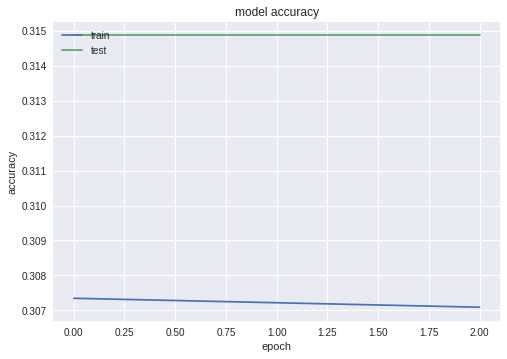

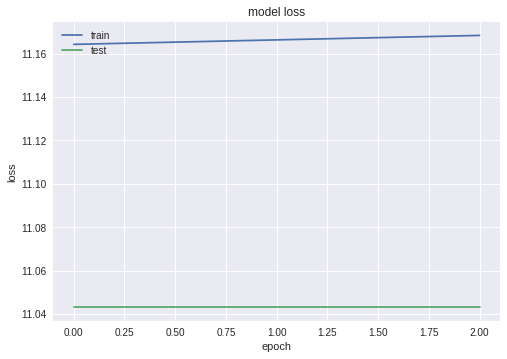

In [79]:
plot_history(hist_mlp)

The progress with this model was pretty slow, as you can see on the graphs. The EarlyStopping monitor also triggered early because the loss didn't improve. The test accuracy and loss flatlined in the last two epochs. I tried experiementing with more nodes on the middle layers, and alternative optimizers like SGD, but none of them improved the results significantly. I simply think this type of network doesn't respond very well to the way I have preprocessed the data in this case.

## FastText Model

Below, I define the FastText model I will use for prediction and classification. I chose to create a function for this, such that I can reuse this code later on.

Here, I am using several new layer types. 
* One is called the Embedding layer. In the code below, it is the first layer added to my model (an embedding layer can only be the first layer of the model). This layer essentially functions as a trainable lookup table for the entire dataset. It offers speedups, but also enables better performance in some cases.
* The next layer is the GlobalAveragePooling1D, which will average the embeddings created earlier. This enables the model to, among others, see the connections between the X and the Y in a performant manner.
* Lastly, I define 3 output layers because I have 3 possible authors.





In [0]:
def fasttext_model(input_dim, embedding_dims=20, optimizer='adam'):
  model = Sequential()
  
  model.add(Embedding(input_dim=input_dim, output_dim=embedding_dims))
  
  # Here I add a GlobalAveragePooling1D, which will average the embeddings of all words in the document
  model.add(GlobalAveragePooling1D())
  
  # I project the results to the final layer of the model, consisting of 3 nodes representing each of our authors.
  # In this case, I chose to use softmax for squashing.
  model.add(Dense(3, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  
  return model

I will now use the model we defined above. I set the input dimensions to be the maximum value in any of the sequenced rows (and +1 to compensate for zero-indexing).

In [0]:
input_dim = np.max(train_text) + 1
model_fasttext = fasttext_model(input_dim)

Now, let's fit the model.

In [82]:
epochs = 25

hist_fasttext = model_fasttext.fit(x_train, y_train, batch_size=16, validation_data=(x_test, y_test), epochs=epochs, callbacks=[EarlyStopping(patience=2, monitor='val_loss')])

Train on 15663 samples, validate on 3916 samples
Epoch 1/25
15663/15663 [==============================] - 7s 464us/step - loss: 1.0787 - acc: 0.4029 - val_loss: 1.0616 - val_acc: 0.4073
Epoch 2/25
15663/15663 [==============================] - 6s 411us/step - loss: 1.0160 - acc: 0.4865 - val_loss: 0.9675 - val_acc: 0.5398
Epoch 3/25
15663/15663 [==============================] - 6s 409us/step - loss: 0.8900 - acc: 0.6501 - val_loss: 0.8467 - val_acc: 0.6609
Epoch 4/25
15663/15663 [==============================] - 6s 406us/step - loss: 0.7626 - acc: 0.7371 - val_loss: 0.7484 - val_acc: 0.7352
Epoch 5/25
15663/15663 [==============================] - 6s 408us/step - loss: 0.6579 - acc: 0.7850 - val_loss: 0.6739 - val_acc: 0.7352
Epoch 6/25
15663/15663 [==============================] - 6s 406us/step - loss: 0.5748 - acc: 0.8155 - val_loss: 0.6142 - val_acc: 0.7717
Epoch 7/25
15663/15663 [==============================] - 6s 406us/step - loss: 0.5082 - acc: 0.8394 - val_loss: 0.5702 - v

That's a pretty solid accuracy! I will now plot the results again to illustrate the models learning curve.

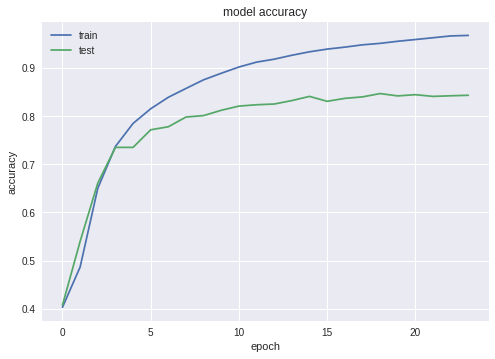

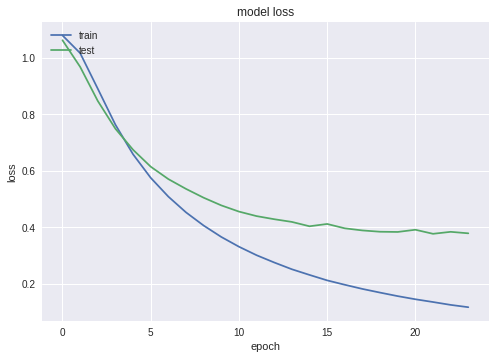

In [83]:
plot_history(hist_fasttext)

The loss and accuracy curve here is pretty normal. The accuracy goes up and the loss goes down very fast in the start, and then settles off at the last epochs.

## LSTM Model

I will also try an LSTM Model. This one takes quite a long time, so feel free to skip it ;)

An LSTM model, or Long Short Term Memory, is a special kind of neural network, which operates on the premis of a so called Cell State. It essentially retains information from previous epochs in a larger degree than other networks. This is quite effective in theory, but it's also quite slow in comparison to the other models i try in this assignment.

As you can see in the code, we once again define an Embedding layer, this time limiting the features of each vector to 1000. As in other models, the output layers will contain 3 nodes, since that is the amount of authors we want to predict for.

In [0]:
input_shape = train_text.shape
#input_shape = train_text.shape
def lstm_model(input_shape, max_features=1000, optimizer='adam'):
  model = Sequential()
  model.add(Embedding(max_features, 128))
  model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_shape=input_shape))
  model.add(Dense(3, activation='sigmoid'))
  
  # try using different optimizers and different optimizer configs
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  return model

In [0]:
model_lstm = lstm_model(input_shape)

Alright, I will now fit the model on the training data. In this particular case I chose 5 epochs because the model in quite slow, and I increased the batch size to 64. This also speeds the model up, but might have an impact on the accuracy.

In [86]:
epochs = 5

hist_lstm = model_lstm.fit(x_train, y_train, batch_size=64, validation_data=(x_test, y_test), epochs=epochs, callbacks=[EarlyStopping(patience=2, monitor='val_loss')])

Train on 15663 samples, validate on 3916 samples
Epoch 1/5
15663/15663 [==============================] - 178s 11ms/step - loss: 0.8783 - acc: 0.5959 - val_loss: 0.6966 - val_acc: 0.7079
Epoch 2/5
15663/15663 [==============================] - 177s 11ms/step - loss: 0.6384 - acc: 0.7426 - val_loss: 0.6381 - val_acc: 0.7298
Epoch 3/5
15663/15663 [==============================] - 178s 11ms/step - loss: 0.8041 - acc: 0.6423 - val_loss: 0.7743 - val_acc: 0.6599
Epoch 4/5
15663/15663 [==============================] - 179s 11ms/step - loss: 0.7579 - acc: 0.6722 - val_loss: 0.8034 - val_acc: 0.6448


I will once again plot the results.

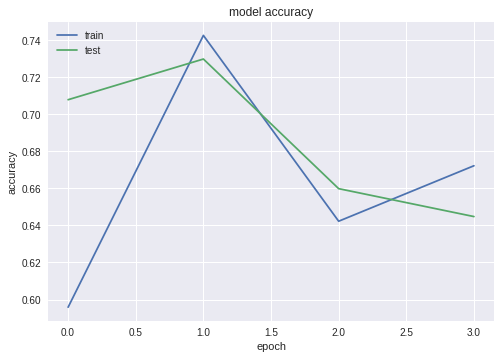

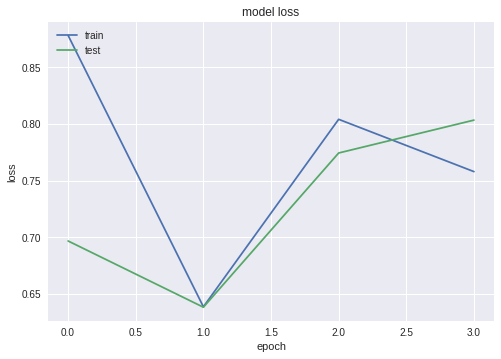

In [87]:
plot_history(hist_lstm)

The graph is quite inconsistent, but I think more epochs would probably solve this to some degree because it gets more time to train.

## Test

Let's test one of the models on the test data! In this case I just use the fasttext model on the test data, because that was the best performing one.

Like with the training data, we preprocess it.

I also create a `pred` variable containing the prediction probabilities.

In [0]:
test_text = preprocess(test_data)
pred_fasttext = model_fasttext.predict_proba(test_text)
pred_classes = np.argmax(pred_fasttext, axis=1)

In [89]:
pred_fasttext

array([[1.7793735e-02, 8.0136669e-01, 1.8083949e-01],
       [8.6870921e-01, 1.3125956e-01, 3.1184270e-05],
       [9.2982185e-01, 2.9999549e-02, 4.0178604e-02],
       ...,
       [5.0895731e-03, 9.9054748e-01, 4.3628979e-03],
       [9.1613936e-01, 2.1669893e-02, 6.2190786e-02],
       [7.5080350e-02, 5.9588808e-01, 3.2903156e-01]], dtype=float32)

Alright, we have predicted the authors for the training data. However, how do we know which author is which in the result?

We can find out by using the `pred_classes` array we made earlier. This contains the labels given by the labelencoder earlier, where each row has the label of the highest scoring author.

Let's use labelencoder to revert the numeric representation to the original values.

In [90]:
labelencoder.inverse_transform(pred_classes)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['HPL', 'EAP', 'EAP', ..., 'HPL', 'EAP', 'HPL'], dtype=object)

As we see, the highest scoring author on the first row is HPL, and on the second row it's EAP. Given this, and by looking at the results we printed earlier, the order of authors in the resulting scores are EAP, HPL and MWS.

Let's insert the results in a new DataFrame.

In [0]:
def save_results(pred):
  result = pd.DataFrame(pred, columns=['EAP','HPL','MWS'])
  result.insert(0, 'id', test_data['id'])
  result.head(20)
  
  return result

Lastly, we'll save the results to a CSV-file for submission.

In [0]:
result = save_results(pred_fasttext)
result.to_csv('submission_fasttext.csv', index=False)

## Different preprocessing approach

For now, I have pretty much used the default Keras tokenizer. I will now try a different approach by manually processing each sentence.

The first function will take all of the special characters in a sentence, and put a space on each side of them, thus treating them as a seperate word when we later tokenize it. This allows the model to also account for different use of these characters by each author.

In [0]:
def preprocess(text):
  # Split the ' character from words, effectively treating it as a separate word.
  text = text.replace("' ", " ' ")
  # Create a set containing the characters we want to filter out
  signs = set(',.:;"?!')
  # Define an intersection of our text and the characters. This will contain all words where these characters are present at the beginning or the end
  prods = set(text) & signs
  # If the prods variable is empty, just return the text since we don't need to do anything else
  if not prods:
      return text
  # For every character in the prods set, replace the character by itself, but with a space on each side of it, thus treatig it as a seperate word when we tokenize it
  for sign in prods:
    text = text.replace(sign, ' {} '.format(sign) )
    
  return text

In my second function, I generate the list of sentences, this time with added n-grams (more specifically bi-grams in my case). For each sentence, I preprocess it and add bigrams. This makes the sentences more trainable.

In [0]:
def create_sentence_list(df, n_gram_max=2):
  def add_ngram(q, n_gram_max):
    ngrams = []
    for n in range(2, n_gram_max+1):
      for w_index in range(len(q)-n+1):
        ngrams.append('--'.join(q[w_index:w_index+n]))
        return q + ngrams
      
  # Let's create a new list called docs
  docs = []
  # Here, I do a for loop, looping over each text row in the dataset
  for doc in df.text:
    # I use the preprocess function defined above on the current row, and then split the text into a new list
    doc = preprocess(doc).split()
    # Lastly, I add the ngrams to the preprocessed text, and append the result to the docs list
    docs.append(' '.join(add_ngram(doc, n_gram_max)))
        
  return docs

Lastly, I use the Keras tokenizer once again, but this time on my manually preprocessed text. Also please notice that I set the filters to be empty, thereby preventing it to remove the characters I have just split from the words.

In [0]:
def tokenize_data(data):
  sentence_list = create_sentence_list(data)
  tokenizer = Tokenizer(lower=False, filters='')
  tokenizer.fit_on_texts(sentence_list)
  num_words = sum([1 for _, v in tokenizer.word_counts.items() if v >= 2])

  tokenizer = Tokenizer(num_words=num_words, lower=False, filters='')
  tokenizer.fit_on_texts(sentence_list)
  sentence_list = tokenizer.texts_to_sequences(sentence_list)

  sentence_list = pad_sequences(sequences=sentence_list, maxlen=256)
  
  return sentence_list

Finally, I use the three functions I have created above on the actual training data. The `tokenize_data` function uses the `create_sentence_list` function, which lastly uses the `preprocess` function, so they are all used in the definition below.

In [0]:
sentence_list = tokenize_data(train_data)

In [0]:
input_dim = np.max(sentence_list) + 1
embedding_dims = 20

Alright, let's train the network! Once again I use 25 epochs, but with EarlyStopping to prevent it running for too long and overfitting too much.

In [98]:
epochs = 25

x_train, x_test, y_train, y_test = train_test_split(sentence_list, y, test_size=0.2)

model_fasttext_new = fasttext_model(input_dim)

hist_fasttext_new = model_fasttext_new.fit(x_train, y_train, batch_size=16, validation_data=(x_test, y_test), epochs=epochs, callbacks=[EarlyStopping(patience=2, monitor='val_loss')])

Train on 15663 samples, validate on 3916 samples
Epoch 1/25
15663/15663 [==============================] - 7s 477us/step - loss: 1.0769 - acc: 0.4036 - val_loss: 1.0553 - val_acc: 0.4354
Epoch 2/25
15663/15663 [==============================] - 6s 398us/step - loss: 1.0091 - acc: 0.5017 - val_loss: 0.9572 - val_acc: 0.5258
Epoch 3/25
15663/15663 [==============================] - 6s 395us/step - loss: 0.8838 - acc: 0.6423 - val_loss: 0.8377 - val_acc: 0.7188
Epoch 4/25
15663/15663 [==============================] - 6s 397us/step - loss: 0.7594 - acc: 0.7412 - val_loss: 0.7369 - val_acc: 0.7551
Epoch 5/25
15663/15663 [==============================] - 6s 394us/step - loss: 0.6570 - acc: 0.7866 - val_loss: 0.6623 - val_acc: 0.7462
Epoch 6/25
15663/15663 [==============================] - 6s 397us/step - loss: 0.5780 - acc: 0.8128 - val_loss: 0.6044 - val_acc: 0.7781
Epoch 7/25
15663/15663 [==============================] - 6s 401us/step - loss: 0.5130 - acc: 0.8319 - val_loss: 0.5563 - v

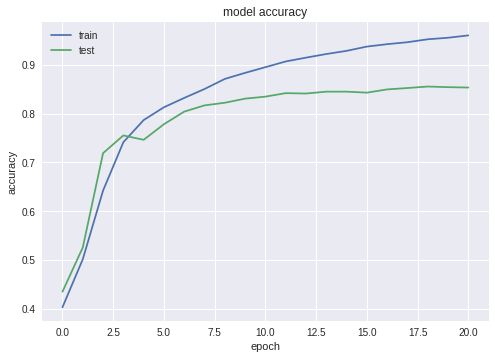

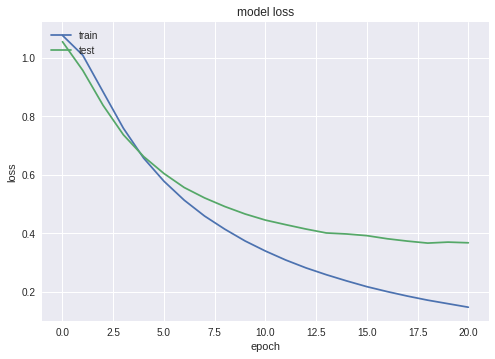

In [99]:
plot_history(hist_fasttext_new)

This is a pretty great result! Let's try to apply it to the test data!

### Test Data

I do the same as above, creating my preproccesed data, this time with the test data.

In [0]:
sentence_list_test = tokenize_data(test_data)

In [0]:
input_dim_test = np.max(sentence_list_test) + 1
embedding_dims = 20

In [0]:
pred_fasttext_new = model_fasttext_new.predict_proba(sentence_list_test)

In [103]:
pred_fasttext_new

array([[0.42261317, 0.07663284, 0.500754  ],
       [0.17191972, 0.6642805 , 0.16379976],
       [0.00489638, 0.02826327, 0.9668404 ],
       ...,
       [0.11056028, 0.27287367, 0.61656606],
       [0.9681949 , 0.00484569, 0.02695943],
       [0.7841938 , 0.1543639 , 0.06144232]], dtype=float32)

Looks good to me. I will now use the function I created earlier to save the results to a CSV file.

In [0]:
result = save_results(pred_fasttext_new)
result.to_csv('submission_fasttext_new.csv', index=False)

# Using Spacy instead of Keras Tokenizer

In the above, I pretty much just used the Keras tokenizer for preprocessing, lastly with some manual work. I will now try to use Spacy to do all of the preprocessing.

First off, I import Spacy and download the model data for english.

In [0]:
import spacy

In [106]:
!python -m spacy download en


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



I'm now gonna load the english model.

In [0]:
nlp = spacy.load('en')

I use the map function of the DataFrame to convert each sentence to a vector using Spacy.

In [0]:
train_text = train_data.text.map(lambda t: nlp(t).vector)

In [109]:
train_text.head()

0    [0.7991028, -0.004031174, 0.14975227, 1.126899...
1    [0.29902083, -0.2551408, 0.48548406, 1.6784768...
2    [0.39712566, 0.015796196, 0.3258409, 1.4247493...
3    [0.54161054, 0.0051353606, 0.037804116, 0.4706...
4    [0.2621837, -0.07247542, 0.33382383, 0.9815354...
Name: text, dtype: object

And lastly, I stack the vector vertically to make it usable by my models.

In [0]:
train_text = np.vstack(train_text)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(train_text, y, test_size=0.2)

In [0]:
input_dim = train_text.shape[1]
model_mlp = mlp_model(input_dim)

The first model I will test my preprocessed data with, is the first one I used, the MLP model.

In [113]:
epochs = 25

hist_mlp_spacy = model_mlp.fit(x_train, y_train, batch_size=16, validation_data=(x_test, y_test), epochs=epochs, callbacks=[EarlyStopping(patience=2, monitor='val_loss')])

Train on 15663 samples, validate on 3916 samples
Epoch 1/25
15663/15663 [==============================] - 11s 694us/step - loss: 0.9480 - acc: 0.5598 - val_loss: 0.8360 - val_acc: 0.6195
Epoch 2/25
15663/15663 [==============================] - 9s 598us/step - loss: 0.8376 - acc: 0.6280 - val_loss: 0.8030 - val_acc: 0.6435
Epoch 3/25
15663/15663 [==============================] - 9s 598us/step - loss: 0.8015 - acc: 0.6536 - val_loss: 0.7829 - val_acc: 0.6606
Epoch 4/25
15663/15663 [==============================] - 9s 600us/step - loss: 0.7715 - acc: 0.6661 - val_loss: 0.7711 - val_acc: 0.6675
Epoch 5/25
15663/15663 [==============================] - 9s 600us/step - loss: 0.7547 - acc: 0.6797 - val_loss: 0.7466 - val_acc: 0.6834
Epoch 6/25
15663/15663 [==============================] - 9s 603us/step - loss: 0.7317 - acc: 0.6896 - val_loss: 0.8184 - val_acc: 0.6527
Epoch 7/25
15663/15663 [==============================] - 9s 603us/step - loss: 0.7157 - acc: 0.6960 - val_loss: 0.7101 - 

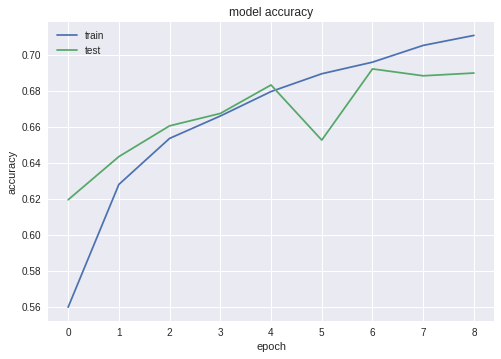

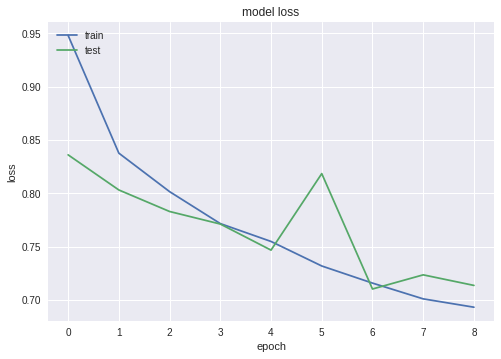

In [114]:
plot_history(hist_mlp_spacy)

The result here is not too bad at all! Next up, let's try with fasttext which performed great before.

In [115]:
model_fasttext = fasttext_model(input_dim)
hist_fasttext_spacy = model_fasttext.fit(x_train, y_train, batch_size=16, validation_data=(x_test, y_test), epochs=epochs, callbacks=[EarlyStopping(patience=2, monitor='val_loss')])

Train on 15663 samples, validate on 3916 samples
Epoch 1/25
15663/15663 [==============================] - 7s 468us/step - loss: 1.0877 - acc: 0.4033 - val_loss: 1.0894 - val_acc: 0.3943
Epoch 2/25
15663/15663 [==============================] - 6s 379us/step - loss: 1.0861 - acc: 0.4058 - val_loss: 1.0909 - val_acc: 0.3943
Epoch 3/25
15663/15663 [==============================] - 6s 379us/step - loss: 1.0847 - acc: 0.4059 - val_loss: 1.0870 - val_acc: 0.3943
Epoch 4/25
15663/15663 [==============================] - 6s 382us/step - loss: 1.0829 - acc: 0.4057 - val_loss: 1.0854 - val_acc: 0.3943
Epoch 5/25
15663/15663 [==============================] - 6s 378us/step - loss: 1.0811 - acc: 0.4075 - val_loss: 1.0838 - val_acc: 0.3943
Epoch 6/25
15663/15663 [==============================] - 6s 381us/step - loss: 1.0796 - acc: 0.4072 - val_loss: 1.0824 - val_acc: 0.3963
Epoch 7/25
15663/15663 [==============================] - 6s 381us/step - loss: 1.0788 - acc: 0.4109 - val_loss: 1.0845 - v

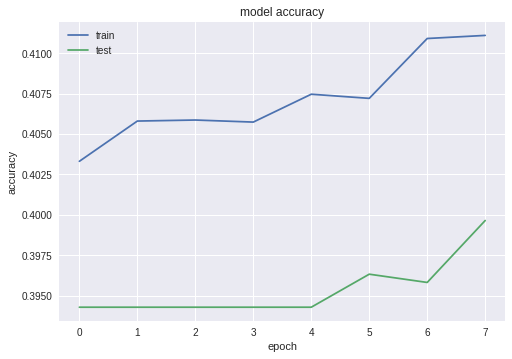

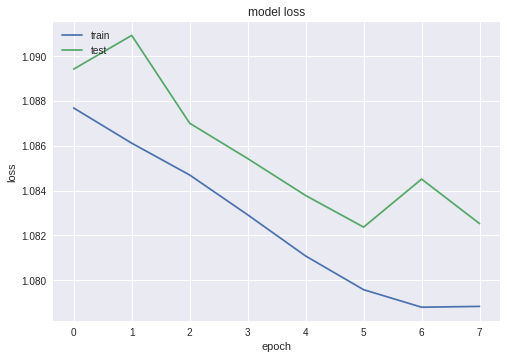

In [116]:
plot_history(hist_fasttext_spacy)

It did much worse this time. Might be because of the way Spacy processes the text, I am not completely sure.

## Test data

I will now apply the Spacy preprocessor to the test data. Since the MLP model performed best with this data, I will create the submission file with that model.

The approach is exactly the same as with the training data.

In [0]:
test_text = test_data.text.map(lambda t: nlp(t).vector)

In [0]:
test_text = np.vstack(test_text)

In [0]:
pred = model_mlp.predict_proba(test_text)

In [0]:
result = save_results(pred)
result.to_csv('submission_spacy.csv', index=False)

# Conclusion

Exploring the sentences with the different models and preprocessing approaches was very interesting! Some models did better than others, but what surprised me the most was the effect that different preprocessing techniques have on the results. It also seems that some models react better or worse to specific types of processing.

More specifically, removing special characters seems to have an effect over not doing so. I assume this is because different authors have different ways to place characters in their sentences.

I could also have

Closing off, since the FastText model with the revised preprocessing did the best, I will rename that to submission.csv as my primary result.

In [0]:
!mv submission_fasttext_new.csv submission.csv

![We did it!](https://i.giphy.com/media/l3vRaWnqG3gOZ8lsk/giphy.webp)<<